In [1]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import fitter
import matplotlib.dates as mdates
import datetime
import matplotlib.ticker as mtick
conn = sqlite3.connect('test_database')
c = conn.cursor()

In [16]:
date_filter = "WHERE date(scheduled_relevant_delivery_date) < date('2022-05-01') AND date(scheduled_relevant_delivery_date) > date('2019-01-01')"

In [17]:
start_date = "2019-01-01"
query = f"""
SELECT Scheduled_relevant_delivery_date, avg(days_late)
FROM(
SELECT base.PO_Number, base.PO_Line_Number, base.Vendor_number, base.Material, base.Material_Group, base.PO_Document_Date, base.Scheduled_relevant_delivery_date, base.Posting_Date, base.days_late, base.expected_lead_time,
    mat_table.material_order_history, mat_table.avg_material_late,
    supplier_material_table.supplier_material_order_history, supplier_material_table.avg_supplier_material_late, supplier_material_table.supplier_total_order_history, supplier_material_table.avg_supplier_general_late,
    po_table.number_line_items,
    sched_table.avg_MOQ, sched_table.avg_unit_price, sched_table.avg_min_price,
    base.delivery_month, base.dayofweek, base.time, base.delivery_season
FROM (
    SELECT PO_Number, PO_Line_Number, Vendor_number, Material, Material_Group, PO_Document_Date, Scheduled_relevant_delivery_date, Posting_Date, -(julianday(Scheduled_relevant_delivery_date) - julianday(Posting_Date)) as days_late, -(julianday(PO_Document_Date) - julianday(Scheduled_relevant_delivery_date)) as expected_lead_time, -(julianday("{start_date}") - julianday(Scheduled_relevant_delivery_date)) as time,
        CASE cast (strftime('%m', Scheduled_relevant_delivery_date) as integer)
          when 1 then 'Jan'
          when 2 then 'Feb'
          when 3 then 'Mar'
          when 4 then 'April'
          when 5 then 'May'
          when 6 then 'June'
          when 7 then 'July'
          when 8 then 'Aug'
          when 9 then 'Sep'
          when 10 then 'Oct'
          when 11 then 'Nov'
          else 'Dec'
        end as delivery_month,
        CASE cast (strftime('%m', Scheduled_relevant_delivery_date) as integer)
          when 1 then 'Winter'
          when 2 then 'Winter'
          when 3 then 'Spring'
          when 4 then 'Spring'
          when 5 then 'Spring'
          when 6 then 'Summer'
          when 7 then 'Summer'
          when 8 then 'Summer'
          when 9 then 'Fall'
          when 10 then 'Fall'
          when 11 then 'Fall'
          else 'Winter'
        end as delivery_season,
        case cast (strftime('%w', Scheduled_relevant_delivery_date) as integer)
          when 0 then 'Sunday'
          when 1 then 'Monday'
          when 2 then 'Tuesday'
          when 3 then 'Wednesday'
          when 4 then 'Thursday'
          when 5 then 'Friday'
          else 'Saturday'
        end as dayofweek
    FROM reliability_table
    {date_filter}
) as base
LEFT JOIN (
    SELECT material_group, count(*) as material_order_history, avg(-(julianday(Scheduled_relevant_delivery_date) - julianday(Posting_Date))) as avg_material_late
    FROM reliability_table
    {date_filter}
    GROUP BY material_group
) as mat_table on mat_table.material_group = base.Material_Group
LEFT JOIN (
    SELECT t1.vendor_number, t1.material_group, t1.supplier_material_order_history, t1.avg_supplier_material_late, t2.supplier_total_order_history, t2.avg_supplier_general_late
    FROM (
        SELECT vendor_number, material_group, count(*) as supplier_material_order_history, avg(-(julianday(Scheduled_relevant_delivery_date) - julianday(Posting_Date))) as avg_supplier_material_late
        FROM reliability_table
        {date_filter}
        GROUP BY vendor_number, material_group) as t1
    LEFT JOIN (
        SELECT vendor_number, count(*) as supplier_total_order_history, avg(-(julianday(Scheduled_relevant_delivery_date) - julianday(Posting_Date))) as avg_supplier_general_late
        FROM reliability_table
        {date_filter}
        GROUP BY vendor_number)  as t2 on t2.vendor_number = t1.vendor_number
) as supplier_material_table on (supplier_material_table.vendor_number = base.Vendor_number AND base.Material_Group=supplier_material_table.material_group)
LEFT JOIN (
    SELECT PO_number, count(distinct PO_Line_Number) as number_line_items
    FROM reliability_table
    {date_filter}
    GROUP BY PO_Number
) as po_table on po_table.PO_number=base.PO_Number
LEFT JOIN (
    SELECT material_group, avg(Minimum_QTY) as avg_MOQ, avg(PPU) as avg_unit_price, avg(order_price) as avg_min_price
    FROM schedule_table
    LEFT JOIN components_table as c on c.part_number = schedule_table.material
    GROUP BY material_group
) as sched_table on sched_table.material_group = base.Material_Group
{date_filter}
ORDER BY Scheduled_relevant_delivery_date
) as fatty
group by Scheduled_relevant_delivery_date
"""
df = pd.read_sql_query(query,conn)
df

,Scheduled_relevant_delivery_date,avg(days_late)
0,2019-03-01 00:00:00,-0.382979
1,2019-03-04 00:00:00,-6.701754
2,2019-03-05 00:00:00,-1.608108
3,2019-03-06 00:00:00,-4.656250
4,2019-03-07 00:00:00,-1.217949
...,...,...
855,2022-04-25 00:00:00,-1.888889
856,2022-04-26 00:00:00,-0.730769
857,2022-04-27 00:00:00,-0.607843
858,2022-04-28 00:00:00,-1.533333


(array([18017., 18140., 18262., 18383., 18506., 18628., 18748., 18871.,
        18993., 19113.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

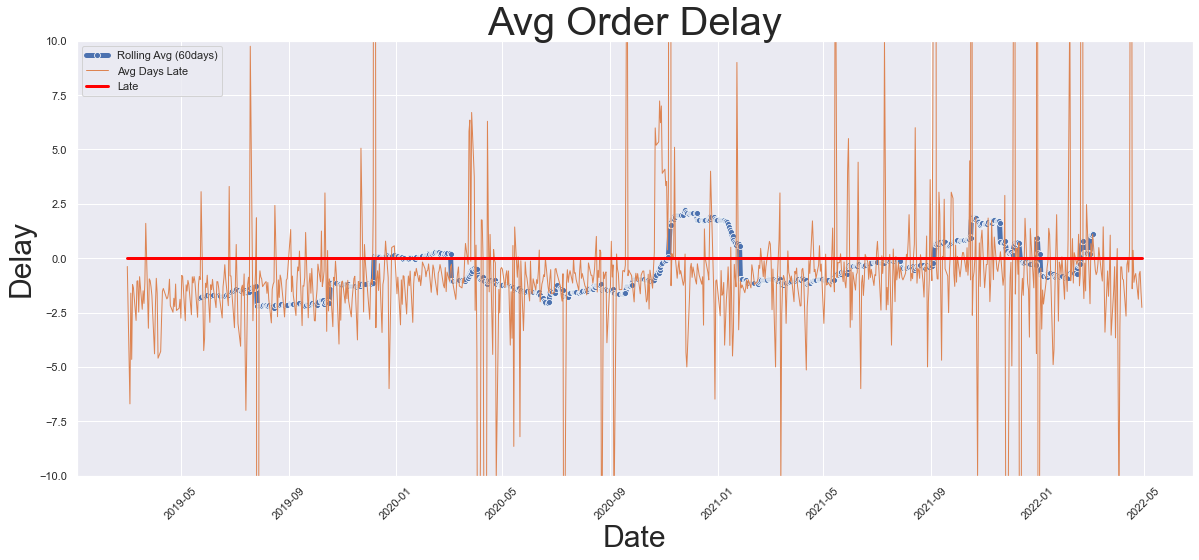

In [18]:
df['Rolling Avg'] = df['avg(days_late)'].rolling(60).mean()
df['EWMA'] = pd.Series.ewm(df['avg(days_late)'], span=60).mean()
df['Late Line'] = 0
sns.set(rc={'figure.figsize':(20,8)})
g = sns.lineplot( x=pd.to_datetime(df['Scheduled_relevant_delivery_date'], format='%Y-%m-%d'), y=df['Rolling Avg'], marker='o', lw=5, label="Rolling Avg (60days)")
sns.lineplot( x=pd.to_datetime(df['Scheduled_relevant_delivery_date'], format='%Y-%m-%d'), y=df['avg(days_late)'], lw=1, label="Avg Days Late")
# sns.lineplot( x=pd.to_datetime(df['Scheduled_relevant_delivery_date'], format='%Y-%m-%d'), y=df['EWMA'], lw=5, label="EWMA", marker='x')
sns.lineplot( x=pd.to_datetime(df['Scheduled_relevant_delivery_date'], format='%Y-%m-%d'), y=df['Late Line'], lw=3, label="Late", color = "red")
g.set_xlabel( "Date" , size = 30 )
g.set_ylabel("Delay", size = 30)
g.set_title( "Avg Order Delay" , size = 40 )
# plt.xlim(pd.to_datetime('2019-05-15'), pd.to_datetime('2022-07-01'))
plt.ylim(-10, 10)
plt.xticks(rotation=45)
# plt.savefig("Lateness_time.png")